<a href="https://colab.research.google.com/github/GHILENISABEUR/Django_rest_framework_crud/blob/main/souhail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 2: Install compatible numpy and pmdarima versions
!pip install numpy==1.26.4
!pip install --force-reinstall pmdarima==2.0.4


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import io
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Sample data (replace with your full data)
data = """
| date | No_ | Description | Quantity | Unit Price | Amount |
|:-----|:----|:------------|:---------|:-----------|:-------|
| 2024-11-16 | TS57 | THON ENTIER.160 Gr SD-HV-EMBOUT | 5000 | 4.261 | 21305 |
| 2024-11-16 | TS17 | THON ENTIER.620 Gr HV-ON  SD | 840 | 15.053 | 12644.52 |
| 2024-03-12 | SD2 | SARDINES 120 Gr TO-OF SD | 500 | 2.238 | 1119 |
"""

# Load data
df = pd.read_csv(
    io.StringIO(data),
    sep='|',
    skiprows=3,
    usecols=[1, 2, 3, 4, 5, 6],
    names=['date', 'No_', 'Description', 'Quantity', 'Unit Price', 'Amount'],
    engine='python'
)

df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='raise')
df['Quantity'] = pd.to_numeric(df['Quantity'])
df['Unit Price'] = pd.to_numeric(df['Unit Price'])
df['Amount'] = pd.to_numeric(df['Amount'])

# Process data - use full 2024 data for training
df = df[df['date'].dt.year == 2024]
daily_sales = df.groupby('date')['Amount'].sum().reset_index()
daily_sales.set_index('date', inplace=True)

# Create complete date range for 2024
idx = pd.date_range('2024-01-01', '2024-12-31')
daily_sales = daily_sales.reindex(idx, fill_value=0)
daily_sales.index.name = 'date'

# Train on all 2024 data
train = daily_sales.loc['2024-01-01':'2024-12-31']

# Forecast period (Jan-Mar 2025)
forecast_dates = pd.date_range('2025-01-01', '2025-03-31')

# 1. Naive forecast
last_value = train['Amount'][-1]
forecast_naive = np.repeat(last_value, len(forecast_dates))

# 2. Exponential Smoothing
model_es = ExponentialSmoothing(train['Amount'], trend='add', seasonal='add', seasonal_periods=7).fit()
forecast_es = model_es.forecast(len(forecast_dates))

# 3. SARIMAX
model_sarimax = SARIMAX(train['Amount'], order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
forecast_sarimax = model_sarimax.forecast(len(forecast_dates))

# 4. Prophet
prophet_train = train.reset_index().rename(columns={'date':'ds', 'Amount':'y'})
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_train)
future = prophet_model.make_future_dataframe(periods=len(forecast_dates), freq='D', include_history=False)
forecast_prophet = prophet_model.predict(future)['yhat'].values

# 5. XGBoost Regression
def create_lags(series, lags=14):
    df_lag = pd.DataFrame()
    for lag in range(1, lags+1):
        df_lag[f'lag_{lag}'] = series.shift(lag)
    return df_lag

lags = 14
df_lags = create_lags(daily_sales['Amount'], lags)
df_lags['target'] = daily_sales['Amount']
df_lags.dropna(inplace=True)

X = df_lags.drop(columns='target')
y = df_lags['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
xgb_model.fit(X_scaled, y)

# Prepare data for forecasting
last_known_values = daily_sales['Amount'].values[-lags:].reshape(1, -1)
forecast_xgb = []

for _ in range(len(forecast_dates)):
    # Scale the input
    input_scaled = scaler.transform(last_known_values)
    # Make prediction
    pred = xgb_model.predict(input_scaled)[0]
    forecast_xgb.append(pred)
    # Update last known values
    last_known_values = np.roll(last_known_values, -1)
    last_known_values[0, -1] = pred

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Naive': forecast_naive,
    'ExponentialSmoothing': forecast_es.values,
    'SARIMAX': forecast_sarimax.values,
    'Prophet': forecast_prophet,
    'XGBoost': forecast_xgb
})

# Plotting
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(train.index, train['Amount'], label='2024 Actual Sales', color='black', linewidth=2)

# Plot forecasts with different colors
colors = ['red', 'blue', 'green', 'purple', 'orange']
models = ['Naive', 'ExponentialSmoothing', 'SARIMAX', 'Prophet', 'XGBoost']
for model, color in zip(models, colors):
    plt.plot(forecast_df['Date'], forecast_df[model], label=f'2025 {model} Forecast',
             linestyle='--', color=color, alpha=0.8)

# Formatting
plt.title('Sales Forecast: 2024 Actual vs 2025 Predictions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print forecast values
print("\nForecast values for January-March 2025:")
print(forecast_df)

# Calculate and print average monthly forecasts
monthly_forecast = forecast_df.copy()
monthly_forecast['Month'] = monthly_forecast['Date'].dt.to_period('M')
monthly_avg = monthly_forecast.groupby('Month').mean(numeric_only=True)

print("\nAverage Monthly Forecasts for 2025:")
print(monthly_avg)

<ipython-input-11-4435079da889>:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


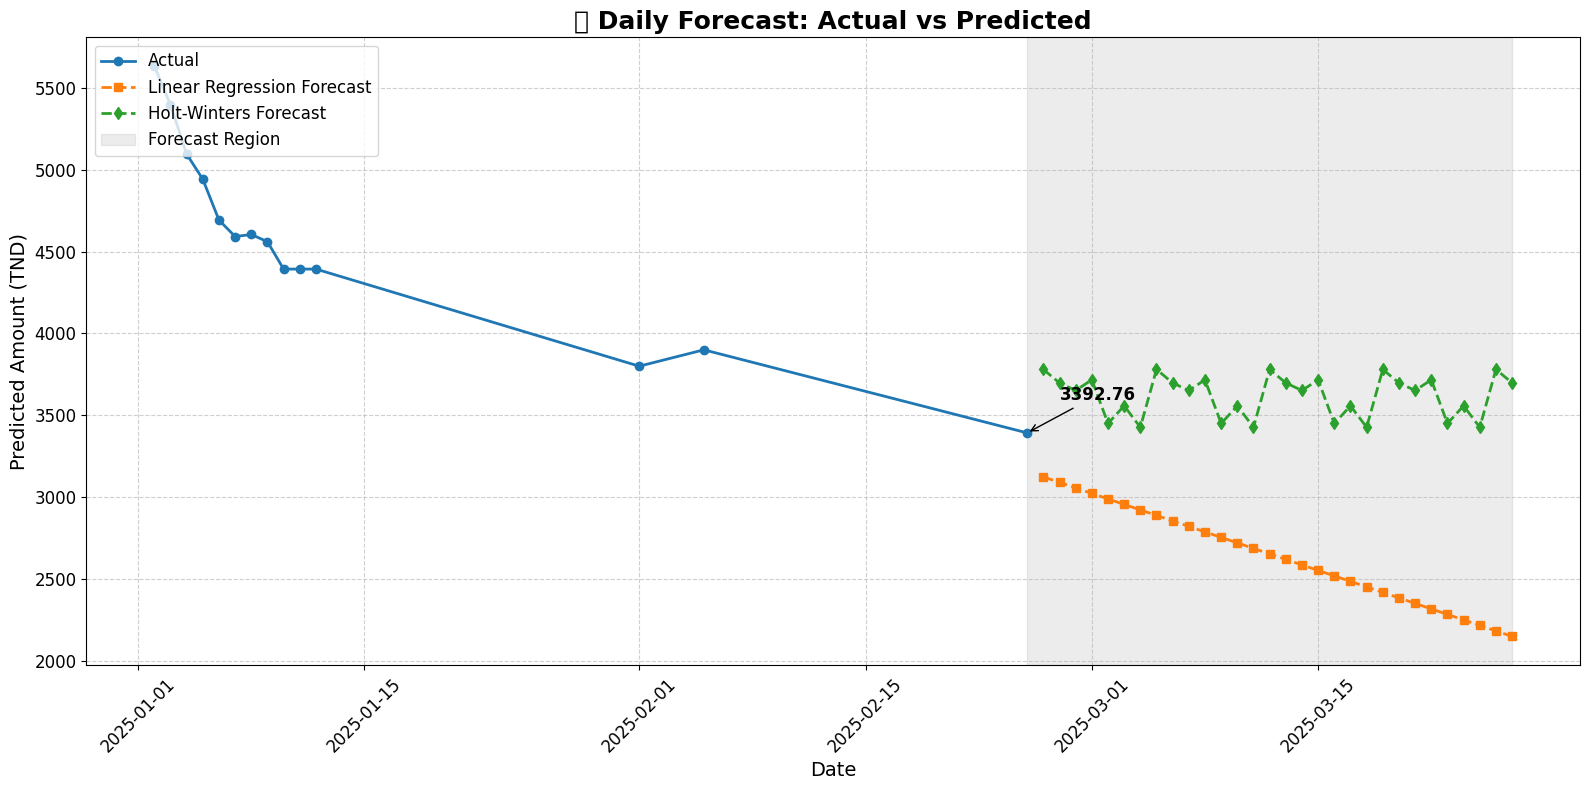

In [ ]:
# 1. Install dependencies
!pip install pandas numpy matplotlib statsmodels scikit-learn --quiet

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# 3. Load and clean data
def load_and_clean_data(file_content):
    lines = [line.split('|') for line in file_content.strip().split('\n')[2:]]
    data = []
    for line in lines:
        if len(line) >= 3:
            date_str = line[1].strip()
            amount = line[2].strip()
            if date_str and amount.replace('.', '', 1).isdigit():
                data.append([date_str, float(amount)])
    df = pd.DataFrame(data, columns=['date', 'predicted_amount'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.groupby('date')['predicted_amount'].first().reset_index()  # remove duplicates
    return df

# 4. Forecasting models (daily level)
def forecast_models_daily(df):
    df_sorted = df.sort_values('date')
    df_sorted['days_since_start'] = (df_sorted['date'] - df_sorted['date'].min()).dt.days

    X = df_sorted['days_since_start'].values.reshape(-1, 1)
    y = df_sorted['predicted_amount'].values

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X, y)

    # Holt-Winters
    if len(y) >= 14:
        hw_model = ExponentialSmoothing(y, seasonal='add', seasonal_periods=7).fit()
        hw_forecast = hw_model.forecast(30)
    else:
        hw_forecast = [np.nan] * 30

    # Forecast for next 30 days
    future_days = np.arange(df_sorted['days_since_start'].max() + 1,
                            df_sorted['days_since_start'].max() + 31)
    future_dates = [df_sorted['date'].max() + timedelta(days=i) for i in range(1, 31)]
    lr_forecast = lr_model.predict(future_days.reshape(-1, 1))

    forecast_df = pd.DataFrame({
        'date': future_dates,
        'linear_regression': lr_forecast,
        'holt_winters': hw_forecast
    })

    return forecast_df

# 5. Plotting
def plot_daily_forecast(df, forecast_df):
    plt.figure(figsize=(16, 8))

    # Historical
    plt.plot(df['date'], df['predicted_amount'], 'o-', color='#1f77b4', label='Actual', linewidth=2, markersize=6)

    # Linear Regression Forecast
    plt.plot(forecast_df['date'], forecast_df['linear_regression'], 's--', color='#ff7f0e',
             label='Linear Regression Forecast', linewidth=2, markersize=6)

    # Holt-Winters Forecast
    plt.plot(forecast_df['date'], forecast_df['holt_winters'], 'd--', color='#2ca02c',
             label='Holt-Winters Forecast', linewidth=2, markersize=6)

    # Shaded forecast region
    plt.axvspan(df['date'].max(), forecast_df['date'].max(), color='gray', alpha=0.15, label='Forecast Region')

    # Enhancements
    plt.title('📈 Daily Forecast: Actual vs Predicted', fontsize=18, fontweight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Predicted Amount (TND)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, loc='upper left')
    plt.tight_layout()

    # Annotate last value
    last_val = df.iloc[-1]
    plt.annotate(f'{last_val.predicted_amount:.2f}',
                 xy=(last_val.date, last_val.predicted_amount),
                 xytext=(last_val.date + timedelta(days=2), last_val.predicted_amount + 200),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12, fontweight='bold')

    plt.show()

# 6. Main
if __name__ == "__main__":
    file_content = """
    | date | predicted_amount |
    |:-----|:-----------------|
    | 2025-01-02 00:00:00 | 5634.178409999996 |
    | 2025-01-02 00:00:00 | 5634.178409999996 |
    | 2025-01-03 00:00:00 | 5395.959650000003 |
    | 2025-01-04 00:00:00 | 5095.616130000005 |
    | 2025-01-05 00:00:00 | 4942.183179999999 |
    | 2025-01-06 00:00:00 | 4692.452009999997 |
    | 2025-01-07 00:00:00 | 4592.020099999999 |
    | 2025-01-08 00:00:00 | 4604.349559999996 |
    | 2025-01-09 00:00:00 | 4560.311389999999 |
    | 2025-01-10 00:00:00 | 4393.209479999999 |
    | 2025-01-11 00:00:00 | 4393.209479999999 |
    | 2025-01-12 00:00:00 | 4393.209479999999 |
    | 2025-02-01 00:00:00 | 3800.1239999999993 |
    | 2025-02-05 00:00:00 | 3900.000000000000 |
    | 2025-02-25 00:00:00 | 3392.76464 |
    """

    df = load_and_clean_data(file_content)
    forecast_df = forecast_models_daily(df)
    plot_daily_forecast(df, forecast_df)


In [ ]:
import pandas as pd

df = pd.read_excel("/content/export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'])

# Filter training data for 2023
df_train = df[df['date'].dt.year == 2023]

# Group monthly sales by product
monthly_sales = df_train.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Amount'].sum().reset_index()


<ipython-input-5-34f959d25862>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_train.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Amount'].sum().reset_index()


In [ ]:
print(df['date'].min())
print(df['date'].max())


2024-01-02 00:00:00
2025-02-25 00:00:00


In [ ]:
print(df_prophet.head())
print(df_prophet.columns)


Empty DataFrame
Columns: [ds, y]
Index: []
Index(['ds', 'y'], dtype='object')


In [ ]:
import pandas as pd
from prophet import Prophet

# Load the Excel file
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'])

# Filter data for Jan and Feb 2024
df_train = df[(df['date'] >= '2024-01-01') & (df['date'] < '2024-03-01')]

# Group by month and sum 'Amount'
monthly = df_train.groupby(pd.Grouper(key='date', freq='M'))['Amount'].sum().reset_index()

# Rename columns for Prophet
monthly.columns = ['ds', 'y']

# Check contents
print(monthly)

# Train Prophet
model = Prophet()
model.fit(monthly)

# Forecast March 2024
future = model.make_future_dataframe(periods=1, freq='M')
forecast = model.predict(future)

# Display forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


<ipython-input-10-b89f380325d4>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_train.groupby(pd.Grouper(key='date', freq='M'))['Amount'].sum().reset_index()
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/wc0dh6wh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/c7ltukwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66535', 'data', 'file=/tmp/tmpde06q29d/wc0dh6wh.json', 'init=/tmp/tm

          ds            y
0 2024-01-31  1353673.216
1 2024-02-29  1821545.557


09:14:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2024-01-31  1.353672e+06  1.353672e+06  1.353672e+06
1 2024-02-29  1.821546e+06  1.821546e+06  1.821546e+06
2 2024-03-31  2.321686e+06  2.321686e+06  2.321686e+06


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [ ]:
# Select only relevant columns from the forecast
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Save to CSV
forecast_output.to_csv("forecast_march_2024.csv", index=False)

print("✅ Forecast saved to 'forecast_march_2024.csv'")


✅ Forecast saved to 'forecast_march_2024.csv'


In [ ]:
import pandas as pd
from prophet import Prophet

# Load and prepare data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'])

# Filter Jan & Feb 2024
df_train = df[(df['date'] >= '2024-01-01') & (df['date'] < '2024-03-01')]

# Monthly aggregation (use 'ME' instead of deprecated 'M')
monthly = df_train.groupby(pd.Grouper(key='date', freq='ME'))['Amount'].sum().reset_index()
monthly.columns = ['ds', 'y']  # for Prophet

# Train Prophet model
model = Prophet()
model.fit(monthly)

# Forecast for 3 months
future = model.make_future_dataframe(periods=1, freq='ME')
forecast = model.predict(future)

# Extract relevant forecast columns
forecast_result = forecast[['ds', 'yhat']]
forecast_result.columns = ['ds', 'y_predicted']

# Merge with actuals
comparison = pd.merge(monthly, forecast_result, on='ds', how='outer')

# Calculate error
comparison['error'] = comparison['y'] - comparison['y_predicted']

# Save to CSV
comparison.to_csv("actual_vs_predicted.csv", index=False)

print("✅ Saved actual vs. predicted comparison to 'actual_vs_predicted.csv'")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/19epubqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ldsukj7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67804', 'data', 'file=/tmp/tmpde06q29d/19epubqm.json', 'init=/tmp/tmpde06q29d/ldsukj7r.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelrg99smc0/prophet_model-20250530091806.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:18:06 - cmdstanpy - INFO - Chain [1] start processing
IN

✅ Saved actual vs. predicted comparison to 'actual_vs_predicted.csv'


In [ ]:
# Rename columns for clarity
comparison = comparison.rename(columns={
    'ds': 'Month',
    'y': 'Actual_Sales_Amount',
    'y_predicted': 'Predicted_Sales_Amount',
    'error': 'Prediction_Error'
})

# Save to CSV
comparison.to_csv("actual_vs_predicted_sales.csv", index=False)

print("✅ Saved comparison with clear column names to 'actual_vs_predicted_sales.csv'")


✅ Saved comparison with clear column names to 'actual_vs_predicted_sales.csv'


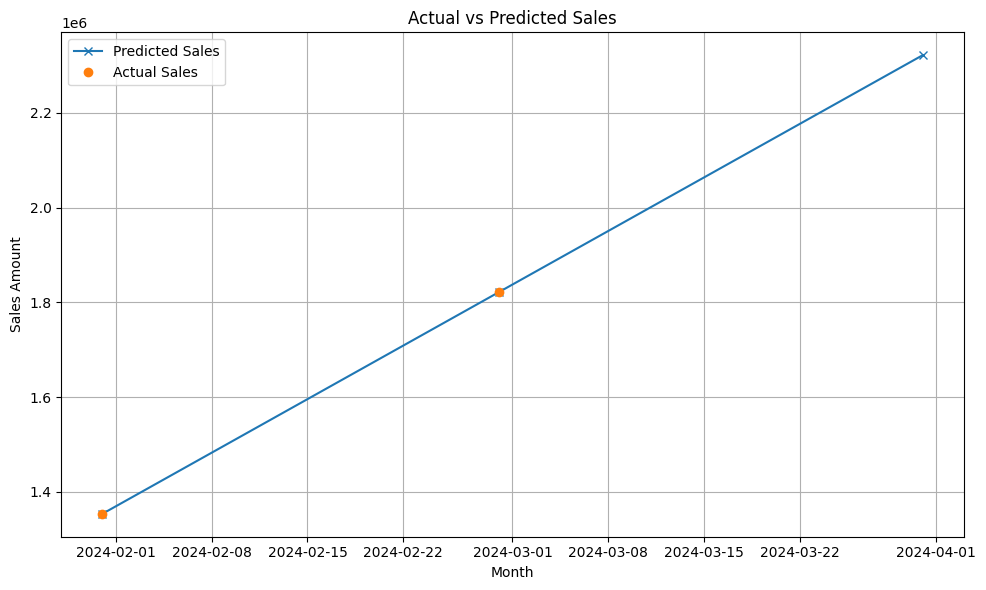

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(comparison['Month'], comparison['Predicted_Sales_Amount'], label='Predicted Sales', marker='x')

# Plot actual only where not NaN
plt.plot(comparison['Month'][comparison['Actual_Sales_Amount'].notna()],
         comparison['Actual_Sales_Amount'][comparison['Actual_Sales_Amount'].notna()],
         label='Actual Sales', marker='o', linestyle='')

plt.title('Actual vs Predicted Sales')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#trained in the wole data


Filtered data starting 2024-01-01: 6801 rows


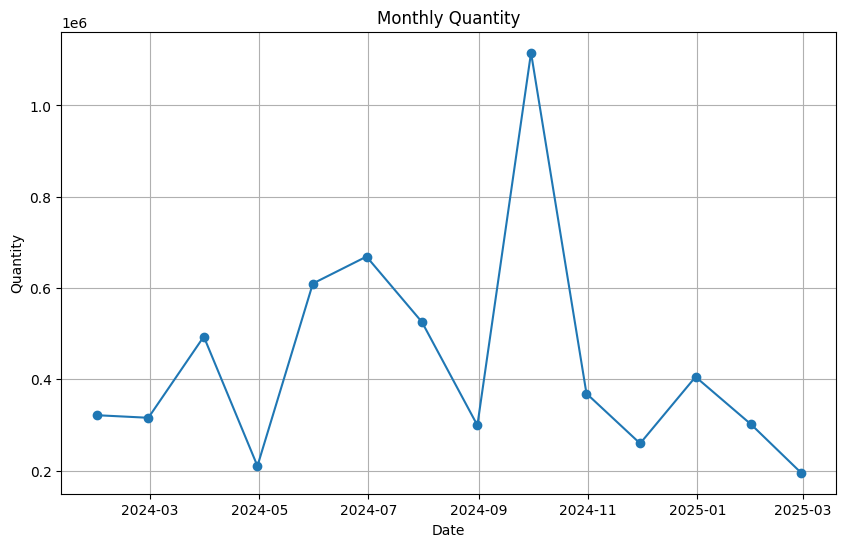

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/1vrqqe_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/l_ebuwtb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98414', 'data', 'file=/tmp/tmpde06q29d/1vrqqe_g.json', 'init=/tmp/tmpde06q29d/l_ebuwtb.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model77w2rhha/prophet_model-20250530093828.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:

✅ Saved actual vs predicted Quantity with tuning to 'actual_vs_predicted_quantity_tuned.csv'


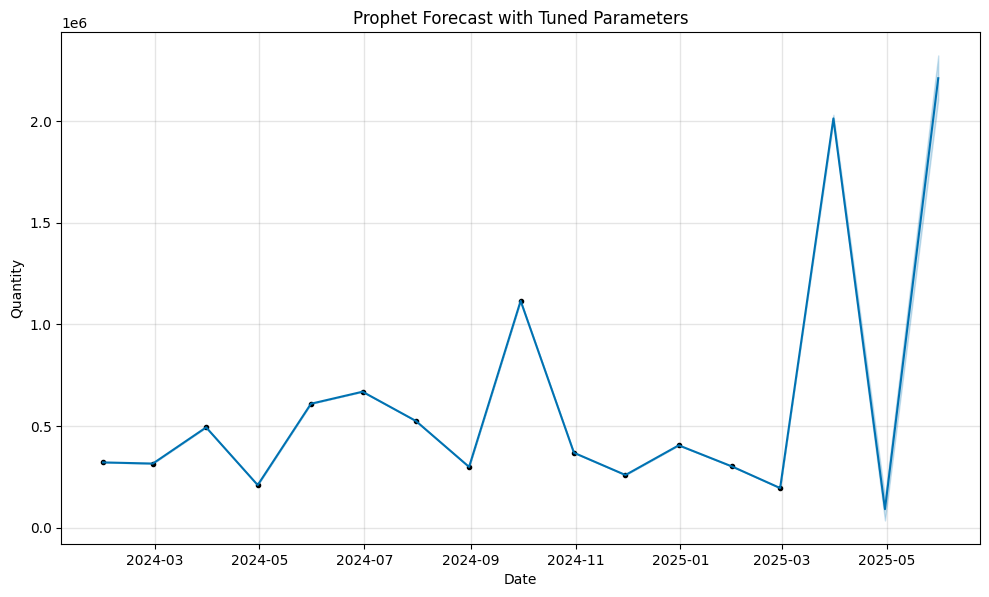

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter data from 2024-01-01 onwards (adjust if you get more history)
df_train = df[df['date'] >= '2024-01-01']
print(f"Filtered data starting 2024-01-01: {df_train.shape[0]} rows")

# Aggregate monthly total Quantity
monthly = df_train.groupby(pd.Grouper(key='date', freq='ME'))['Quantity'].sum().reset_index()
monthly.columns = ['ds', 'y']

# Check enough data points
if monthly['y'].notna().sum() < 2:
    raise ValueError("Not enough data points to train Prophet.")

# Visualize monthly data
plt.figure(figsize=(10, 6))
plt.plot(monthly['ds'], monthly['y'], marker='o')
plt.title("Monthly Quantity")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid(True)
plt.show()

# Initialize Prophet model with more flexible trend and monthly seasonality
model = Prophet(changepoint_prior_scale=0.5, yearly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fit model
model.fit(monthly)

# Forecast next 3 months
future = model.make_future_dataframe(periods=3, freq='ME')
forecast = model.predict(future)

# Extract relevant columns
forecast_result = forecast[['ds', 'yhat']].copy()
forecast_result.columns = ['ds', 'y_predicted']

# Merge actual and predicted
comparison = pd.merge(monthly, forecast_result, on='ds', how='outer')

# Calculate error where actual exists
comparison['error'] = comparison['y'] - comparison['y_predicted']

# Save results to CSV
comparison.to_csv("actual_vs_predicted_quantity_tuned.csv", index=False)

print("✅ Saved actual vs predicted Quantity with tuning to 'actual_vs_predicted_quantity_tuned.csv'")

# Plot forecast with actual data
model.plot(forecast)
plt.title("Prophet Forecast with Tuned Parameters")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()


Filtered data starting 2024-01-01: 6801 rows


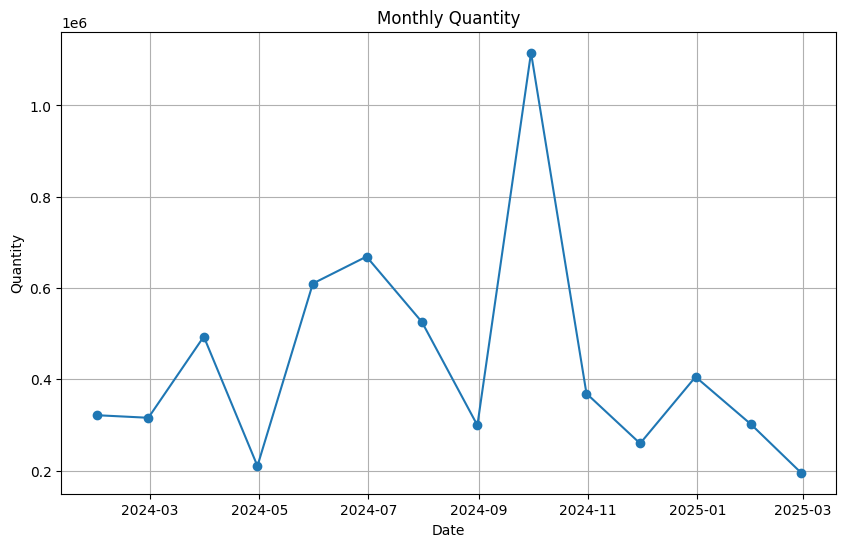

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/u8dtobth.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/k21drihg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86930', 'data', 'file=/tmp/tmpde06q29d/u8dtobth.json', 'init=/tmp/tmpde06q29d/k21drihg.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model26duix7_/prophet_model-20250530094052.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:40:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:41:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:

✅ Saved actual vs predicted Quantity with tuning to 'actual_vs_predicted_quantity_tuned.csv'


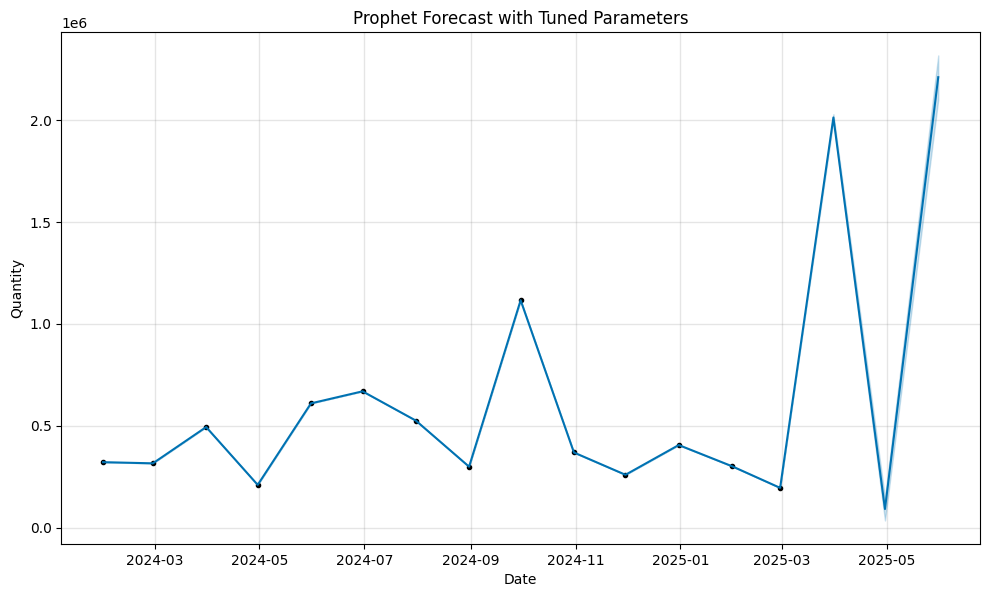

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter data from 2024-01-01 onwards
df_train = df[df['date'] >= '2024-01-01']
print(f"Filtered data starting 2024-01-01: {df_train.shape[0]} rows")

# Aggregate monthly total Quantity
monthly_quantity = df_train.groupby(pd.Grouper(key='date', freq='ME'))['Quantity'].sum().reset_index()

# Rename for Prophet
prophet_df = monthly_quantity.rename(columns={'date': 'ds', 'Quantity': 'y'})

# Check enough data points
if prophet_df['y'].notna().sum() < 2:
    raise ValueError("Not enough data points to train Prophet.")

# Visualize monthly quantity
plt.figure(figsize=(10, 6))
plt.plot(monthly_quantity['date'], monthly_quantity['Quantity'], marker='o')
plt.title("Monthly Quantity")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid(True)
plt.show()

# Initialize Prophet with tuning
model = Prophet(changepoint_prior_scale=0.5, yearly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fit the model
model.fit(prophet_df)

# Forecast next 3 months
future = model.make_future_dataframe(periods=3, freq='ME')
forecast = model.predict(future)

# Extract relevant columns
forecast_result = forecast[['ds', 'yhat']].copy()
forecast_result.columns = ['date', 'predicted_quantity']

# Merge actual and predicted
comparison = pd.merge(monthly_quantity, forecast_result, on='date', how='outer')

# Calculate error where actual exists
comparison['error'] = comparison['Quantity'] - comparison['predicted_quantity']

# Save results
comparison.to_csv("actual_vs_predicted_quantity_tuned.csv", index=False)

print("✅ Saved actual vs predicted Quantity with tuning to 'actual_vs_predicted_quantity_tuned.csv'")

# Plot forecast with actual data
model.plot(forecast)
plt.title("Prophet Forecast with Tuned Parameters")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()


##added description

In [ ]:
import pandas as pd
from prophet import Prophet

# Load data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check the date range in your dataset
print(f"Data date range: {df['date'].min()} to {df['date'].max()}")

# Adjust this filter based on the actual data range printed above.
# Example: Training on 2024 data, predict first 3 months of 2025
df_train = df[(df['date'] >= '2024-01-01') & (df['date'] < '2025-01-01')]
print(f"Training data rows: {df_train.shape[0]}")

# Get unique product descriptions
products = df_train['Description'].unique()
print(f"Total unique products: {len(products)}")

results = []

for product in products:
    product_data = df_train[df_train['Description'] == product]

    # Aggregate monthly quantity per product
    monthly = product_data.groupby(pd.Grouper(key='date', freq='ME'))['Quantity'].sum().reset_index()
    monthly.rename(columns={'date': 'ds', 'Quantity': 'y'}, inplace=True)

    valid_points = monthly['y'].notna().sum()
    print(f"Product: {product} | Non-null monthly points: {valid_points}")

    if valid_points < 2:
        print(f"Skipping '{product}' due to insufficient data")
        continue

    # Train Prophet model
    model = Prophet(changepoint_prior_scale=0.5, yearly_seasonality=True)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(monthly)

    # Forecast next 3 months (e.g., Jan-Mar of next year)
    future = model.make_future_dataframe(periods=3, freq='ME')
    forecast = model.predict(future)

    # Select forecast period only
    forecasted = forecast[['ds', 'yhat']].tail(3)
    forecasted['Description'] = product

    results.append(forecasted)

if results:
    all_forecasts = pd.concat(results)
    all_forecasts.rename(columns={'ds': 'date', 'yhat': 'predicted_quantity'}, inplace=True)
    all_forecasts.to_csv("forecasted_quantities_per_product.csv", index=False)
    print("✅ Saved forecasted quantities per product for next 3 months to 'forecasted_quantities_per_product.csv'")
else:
    print("❌ No products with sufficient data to forecast.")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/jknjzid1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/noi4rrxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20651', 'data', 'file=/tmp/tmpde06q29d/jknjzid1.json', 'init=/tmp/tmpde06q29d/noi4rrxy.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelzsod_oq7/prophet_model-20250530095810.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Data date range: 2024-01-02 00:00:00 to 2025-02-25 00:00:00
Training data rows: 6411
Total unique products: 130
Product: THON ENTIER.160 Gr SD-HV-EMBOUT | Non-null monthly points: 11


09:58:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/4356agf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/umalghw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27775', 'data', 'file=/tmp/tmpde06q29d/4356agf2.json', 'init=/tmp/tmpde06q29d/umalghw4.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model2qxiiptw/prophet_model-20250530095823.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER.620 Gr HV-ON  SD | Non-null monthly points: 12


09:58:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/uokg0vj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/02a9fljc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15811', 'data', 'file=/tmp/tmpde06q29d/uokg0vj1.json', 'init=/tmp/tmpde06q29d/02a9fljc.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modeldh07zg7g/prophet_model-20250530095835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER 2,050 Kg HV-ON  SD | Non-null monthly points: 12


09:58:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/p04_04sw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/p15e1dv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21680', 'data', 'file=/tmp/tmpde06q29d/p04_04sw.json', 'init=/tmp/tmpde06q29d/p15e1dv1.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelhz7mtv6t/prophet_model-20250530095847.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER 1,9 kG HO-ON   SD | Non-null monthly points: 11


09:58:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/_tno15ck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/93himwu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69556', 'data', 'file=/tmp/tmpde06q29d/_tno15ck.json', 'init=/tmp/tmpde06q29d/93himwu5.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelmd8wehqb/prophet_model-20250530095859.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE DE THON 160 GR HO EMBOUT | Non-null monthly points: 12


09:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/gpb3k_st.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/b2mjo0pm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84654', 'data', 'file=/tmp/tmpde06q29d/gpb3k_st.json', 'init=/tmp/tmpde06q29d/b2mjo0pm.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model1sd_p_tp/prophet_model-20250530095911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:59:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER 950 Gr HV-ON   SD | Non-null monthly points: 12


09:59:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/7j0dovn0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/qzmtrkwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36927', 'data', 'file=/tmp/tmpde06q29d/7j0dovn0.json', 'init=/tmp/tmpde06q29d/qzmtrkwx.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelv8_qlcqr/prophet_model-20250530095923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:59:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: FILETS MAQUERAUX 170 Gr HT-OF | Non-null monthly points: 12


09:59:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/dy2r3txu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/tetu4ll4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5983', 'data', 'file=/tmp/tmpde06q29d/dy2r3txu.json', 'init=/tmp/tmpde06q29d/tetu4ll4.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelxjpq5ssu/prophet_model-20250530095936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:59:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Product: LOT 3 BTS SARD.120Gr HO-OF SD | Non-null monthly points: 7


09:59:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/0_v76j4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/8z7mthw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97150', 'data', 'file=/tmp/tmpde06q29d/0_v76j4y.json', 'init=/tmp/tmpde06q29d/8z7mthw1.json', 'output', 'file=/tmp/tmpde06q29d/prophet_models6ptb6eb/prophet_model-20250530095946.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:59:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT 3 BTS SARD.120Gr HV-OF SD | Non-null monthly points: 6


09:59:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/p62tieam.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/aj5auyyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34736', 'data', 'file=/tmp/tmpde06q29d/p62tieam.json', 'init=/tmp/tmpde06q29d/aj5auyyf.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model3dcvwn_3/prophet_model-20250530095955.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE DE THON 80 GR HO EMBOUT | Non-null monthly points: 10


10:00:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/gyrhcyah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/n5qis21o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89297', 'data', 'file=/tmp/tmpde06q29d/gyrhcyah.json', 'init=/tmp/tmpde06q29d/n5qis21o.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelskj84nab/prophet_model-20250530100006.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:00:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE DE THON 400 HV -SD | Non-null monthly points: 12


10:00:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/5qn8g5br.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/r0391eyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88028', 'data', 'file=/tmp/tmpde06q29d/5qn8g5br.json', 'init=/tmp/tmpde06q29d/r0391eyp.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model_8qzo36h/prophet_model-20250530100018.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:00:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 120 Gr HO-OF SD | Non-null monthly points: 12


10:00:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/0px9il2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/cdou5boy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34541', 'data', 'file=/tmp/tmpde06q29d/0px9il2q.json', 'init=/tmp/tmpde06q29d/cdou5boy.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelrvhybqfj/prophet_model-20250530100030.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:00:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 120 Gr TO-OF SD | Non-null monthly points: 12


10:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/5g954w35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/1fh9pg7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16023', 'data', 'file=/tmp/tmpde06q29d/5g954w35.json', 'init=/tmp/tmpde06q29d/1fh9pg7x.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelx33qb1ee/prophet_model-20250530100042.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 120 Gr HV-OF SD | Non-null monthly points: 12


10:00:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/wtmhrelh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/1q607j0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61950', 'data', 'file=/tmp/tmpde06q29d/wtmhrelh.json', 'init=/tmp/tmpde06q29d/1q607j0p.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model009c610h/prophet_model-20250530100054.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 120 Gr CI-OF SD | Non-null monthly points: 11


10:01:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/hd8mznoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/hr1g5arg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94493', 'data', 'file=/tmp/tmpde06q29d/hd8mznoh.json', 'init=/tmp/tmpde06q29d/hr1g5arg.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelb9v7nhog/prophet_model-20250530100106.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:01:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 120 Gr HA-OF SD | Non-null monthly points: 12


10:01:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/g87ewxg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/0dhuwfg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62870', 'data', 'file=/tmp/tmpde06q29d/g87ewxg9.json', 'init=/tmp/tmpde06q29d/0dhuwfg6.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelaovwobtr/prophet_model-20250530100118.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:01:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT 3 BTS OEUF DE THON 120 Gr | Non-null monthly points: 12


10:01:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/kmfc_w2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/0o2ojve7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28183', 'data', 'file=/tmp/tmpde06q29d/kmfc_w2b.json', 'init=/tmp/tmpde06q29d/0o2ojve7.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modeln7aopgks/prophet_model-20250530100130.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:01:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER FRAIS 160 HO-OF SD | Non-null monthly points: 12


10:01:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/dhsv64gj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/_ubhald7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30057', 'data', 'file=/tmp/tmpde06q29d/dhsv64gj.json', 'init=/tmp/tmpde06q29d/_ubhald7.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model9x0xssky/prophet_model-20250530100142.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:01:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOCAUX FIL THON 190Gr HO SD | Non-null monthly points: 11


10:01:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/w6f7bcru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/igzhi5sx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92220', 'data', 'file=/tmp/tmpde06q29d/w6f7bcru.json', 'init=/tmp/tmpde06q29d/igzhi5sx.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modeluzwvmex2/prophet_model-20250530100154.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:01:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: FILETS ANCHOIS 55 GR HO SD | Non-null monthly points: 7


10:02:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/114ptmsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/7hzbh7pu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28355', 'data', 'file=/tmp/tmpde06q29d/114ptmsm.json', 'init=/tmp/tmpde06q29d/7hzbh7pu.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model5lad9ax1/prophet_model-20250530100204.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:02:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ALU.FILET THON 125 Gr Au Ci SD | Non-null monthly points: 9


10:02:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/jj35vk0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/osq0kih8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17671', 'data', 'file=/tmp/tmpde06q29d/jj35vk0v.json', 'init=/tmp/tmpde06q29d/osq0kih8.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelv99p5949/prophet_model-20250530100214.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:02:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOCAUX ANCHOIS 85Gr HT-PI-SD | Non-null monthly points: 7


10:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/pfix9iqv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/5l9ue4gk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33505', 'data', 'file=/tmp/tmpde06q29d/pfix9iqv.json', 'init=/tmp/tmpde06q29d/5l9ue4gk.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelcth_dpwa/prophet_model-20250530100224.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:02:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT 3 BTS SARD.120Gr CI-OF SD | Non-null monthly points: 8


10:02:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/b1skz9ig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/xpjq2e98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38914', 'data', 'file=/tmp/tmpde06q29d/b1skz9ig.json', 'init=/tmp/tmpde06q29d/xpjq2e98.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelnklagdth/prophet_model-20250530100231.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:02:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE THON  400 GR AU NATUREL | Non-null monthly points: 12


10:02:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/dlxjq63q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/a5zivqgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51751', 'data', 'file=/tmp/tmpde06q29d/dlxjq63q.json', 'init=/tmp/tmpde06q29d/a5zivqgb.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model3wgghbou/prophet_model-20250530100243.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:02:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE DE THON 80 GR HV EMBOUT | Non-null monthly points: 12


10:02:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/x_cxg958.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/kgzserdr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39270', 'data', 'file=/tmp/tmpde06q29d/x_cxg958.json', 'init=/tmp/tmpde06q29d/kgzserdr.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelcjjxo_t2/prophet_model-20250530100255.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:02:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER 2 kG -HO-ON   SD | Non-null monthly points: 12


10:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ecr14clx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/e_v_xz5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60690', 'data', 'file=/tmp/tmpde06q29d/ecr14clx.json', 'init=/tmp/tmpde06q29d/e_v_xz5w.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model7lv1e_88/prophet_model-20250530100306.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:03:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT 3 BTS SARD.120Gr TO-OF SD | Non-null monthly points: 10


10:03:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/yn89_9tw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ps_k7v9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63724', 'data', 'file=/tmp/tmpde06q29d/yn89_9tw.json', 'init=/tmp/tmpde06q29d/ps_k7v9d.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model5qd62wpb/prophet_model-20250530100318.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER.160 Gr SD-NAT-FP | Non-null monthly points: 11


10:03:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/xfnc1epp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/_to6lqs5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77346', 'data', 'file=/tmp/tmpde06q29d/xfnc1epp.json', 'init=/tmp/tmpde06q29d/_to6lqs5.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelx04cdrpm/prophet_model-20250530100330.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:03:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER.620 Gr  HO-ON SD | Non-null monthly points: 11


10:03:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/s_33ipev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/0v3ld3kf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86145', 'data', 'file=/tmp/tmpde06q29d/s_33ipev.json', 'init=/tmp/tmpde06q29d/0v3ld3kf.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelsk7cr4sk/prophet_model-20250530100342.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ALU.FILET THON 125 Gr HA SD | Non-null monthly points: 11


10:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/l1r5lbhc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/sun67__m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74988', 'data', 'file=/tmp/tmpde06q29d/l1r5lbhc.json', 'init=/tmp/tmpde06q29d/sun67__m.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelz5roizpq/prophet_model-20250530100354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER.160 Gr SD-HO-FP | Non-null monthly points: 12


10:04:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/qc1qen2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/alrfc_pd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32184', 'data', 'file=/tmp/tmpde06q29d/qc1qen2p.json', 'init=/tmp/tmpde06q29d/alrfc_pd.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelakl_6o20/prophet_model-20250530100406.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:04:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE DE THON 400 HO -SD | Non-null monthly points: 12


10:04:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/y7jh_v0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/xm27qxz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23149', 'data', 'file=/tmp/tmpde06q29d/y7jh_v0n.json', 'init=/tmp/tmpde06q29d/xm27qxz_.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelt1p8shvu/prophet_model-20250530100418.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:04:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER.160 Gr SD-HV-FP | Non-null monthly points: 10


10:04:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/zehyhtbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/wzkvxkyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39805', 'data', 'file=/tmp/tmpde06q29d/zehyhtbw.json', 'init=/tmp/tmpde06q29d/wzkvxkyd.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelc9duipt2/prophet_model-20250530100429.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOCAUX ANCHOIS 85Gr HT-SD | Non-null monthly points: 10


10:04:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/nz3id1j1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/0bnwcb9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93438', 'data', 'file=/tmp/tmpde06q29d/nz3id1j1.json', 'init=/tmp/tmpde06q29d/0bnwcb9i.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modele1i0fo0z/prophet_model-20250530100441.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE THON 1,700 KG AU NATUREL | Non-null monthly points: 6


10:04:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ucr0dqpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ms_3v7y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17831', 'data', 'file=/tmp/tmpde06q29d/ucr0dqpe.json', 'init=/tmp/tmpde06q29d/ms_3v7y0.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelyxqoq2i5/prophet_model-20250530100449.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER.FR 950 Gr.HO-ON SD | Non-null monthly points: 2


10:04:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/h59b67ad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/l78esny4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31463', 'data', 'file=/tmp/tmpde06q29d/h59b67ad.json', 'init=/tmp/tmpde06q29d/l78esny4.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelz7vox0v2/prophet_model-20250530100457.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ALU.FILET SARD 100 Gr HO-OF SD | Non-null monthly points: 8


10:05:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/3h5pvm1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/19lzqrfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36811', 'data', 'file=/tmp/tmpde06q29d/3h5pvm1d.json', 'init=/tmp/tmpde06q29d/19lzqrfm.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelcl0k6h41/prophet_model-20250530100507.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ALU.FILET SARD 100 Gr HT-OF SD | Non-null monthly points: 8


10:05:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/8pkvxg12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/8hgi6k49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33436', 'data', 'file=/tmp/tmpde06q29d/8pkvxg12.json', 'init=/tmp/tmpde06q29d/8hgi6k49.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model3fwgiuuo/prophet_model-20250530100517.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ALU.FILET SARD 100 Gr CI-OF SD | Non-null monthly points: 8


10:05:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/4fz3dbcl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/4pm5lef9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55396', 'data', 'file=/tmp/tmpde06q29d/4fz3dbcl.json', 'init=/tmp/tmpde06q29d/4pm5lef9.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modeluob_kybr/prophet_model-20250530100526.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 120 Gr  AUX PI-OF SD | Non-null monthly points: 11


10:05:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/6lduex6z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/kv5bm9zf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17320', 'data', 'file=/tmp/tmpde06q29d/6lduex6z.json', 'init=/tmp/tmpde06q29d/kv5bm9zf.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model_gtgmnly/prophet_model-20250530100537.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOCAUX FIL THON 190Gr HO-HP SD | Non-null monthly points: 12


10:05:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ukd59q4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/qr5dl1pr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49463', 'data', 'file=/tmp/tmpde06q29d/ukd59q4h.json', 'init=/tmp/tmpde06q29d/qr5dl1pr.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modeld3_epamm/prophet_model-20250530100549.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ALU.FILETS THON 125 Gr HP SD | Non-null monthly points: 12


10:06:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/mgl6q2ms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/eiclnhpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40928', 'data', 'file=/tmp/tmpde06q29d/mgl6q2ms.json', 'init=/tmp/tmpde06q29d/eiclnhpj.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model0a5ctq_7/prophet_model-20250530100601.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE SARDINES 1KG-HV -SD | Non-null monthly points: 11


10:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/06iqx3pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/n9yk2waf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39925', 'data', 'file=/tmp/tmpde06q29d/06iqx3pl.json', 'init=/tmp/tmpde06q29d/n9yk2waf.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelqvmkwxjl/prophet_model-20250530100613.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER 1,9 kG HV-ON   SD | Non-null monthly points: 12


10:06:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/y8lcsc_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/n17klage.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1868', 'data', 'file=/tmp/tmpde06q29d/y8lcsc_5.json', 'init=/tmp/tmpde06q29d/n17klage.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model58_f35nk/prophet_model-20250530100625.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:06:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Product: SARDINES 120 GR -HV KOLL YOUM | Non-null monthly points: 12


10:06:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/rlsz0svm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/npm0e1qz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68301', 'data', 'file=/tmp/tmpde06q29d/rlsz0svm.json', 'init=/tmp/tmpde06q29d/npm0e1qz.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelw0p3ovtm/prophet_model-20250530100636.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 120 GR -HO KOLL YOUM | Non-null monthly points: 12


10:06:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/e5j9v8mm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/hv2g0b5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84010', 'data', 'file=/tmp/tmpde06q29d/e5j9v8mm.json', 'init=/tmp/tmpde06q29d/hv2g0b5h.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelnw7t67ui/prophet_model-20250530100648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOCAUX FIL THON 190Gr HO-Ci SD | Non-null monthly points: 12


10:07:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/e2qzings.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ozm7w6js.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12657', 'data', 'file=/tmp/tmpde06q29d/e2qzings.json', 'init=/tmp/tmpde06q29d/ozm7w6js.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelu35nmwmb/prophet_model-20250530100700.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ALU.FILET THON  125 Gr HO SD | Non-null monthly points: 11


10:07:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/efhx6um3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/fdisyxbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74394', 'data', 'file=/tmp/tmpde06q29d/efhx6um3.json', 'init=/tmp/tmpde06q29d/fdisyxbk.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelp39cmwcy/prophet_model-20250530100712.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENT. SORRA160GR HO-OF SD | Non-null monthly points: 1
Skipping 'THON ENT. SORRA160GR HO-OF SD' due to insufficient data
Product: BOCAUX ANCHOIS 85Gr HT-CA | Non-null monthly points: 8


10:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/16fr1euc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/x8wsg2xl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28480', 'data', 'file=/tmp/tmpde06q29d/16fr1euc.json', 'init=/tmp/tmpde06q29d/x8wsg2xl.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelk8gdylm2/prophet_model-20250530100719.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: Boite Thon 400GR HV-ZEMBRA | Non-null monthly points: 7


10:07:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/o5z7t7hg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/s666g63p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65861', 'data', 'file=/tmp/tmpde06q29d/o5z7t7hg.json', 'init=/tmp/tmpde06q29d/s666g63p.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model76mhx2b4/prophet_model-20250530100730.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: OEUF DE THON 120 Gr HO-SD | Non-null monthly points: 11


10:07:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/w6hp86gg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/exr_ecii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16074', 'data', 'file=/tmp/tmpde06q29d/w6hp86gg.json', 'init=/tmp/tmpde06q29d/exr_ecii.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model5f48u_fr/prophet_model-20250530100742.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 650 GR HV | Non-null monthly points: 11


10:07:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/6gbxxxhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/gl1mdbuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88455', 'data', 'file=/tmp/tmpde06q29d/6gbxxxhx.json', 'init=/tmp/tmpde06q29d/gl1mdbuc.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model0_73s49r/prophet_model-20250530100753.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:07:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: Boite thon 160 GR HO HAND MADE | Non-null monthly points: 7


10:08:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/hok75amp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/en1275vo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66764', 'data', 'file=/tmp/tmpde06q29d/hok75amp.json', 'init=/tmp/tmpde06q29d/en1275vo.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model_ub1iemq/prophet_model-20250530100803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER 950 Gr HO-ON   SD | Non-null monthly points: 12


10:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/0lk8p1iy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ijr3tc5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7257', 'data', 'file=/tmp/tmpde06q29d/0lk8p1iy.json', 'init=/tmp/tmpde06q29d/ijr3tc5o.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model57n1vcsd/prophet_model-20250530100814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:08:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Product: THON ENTIER.300 Gr  HO-OF SD | Non-null monthly points: 3


10:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/n2u38dt8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/gu294g34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15469', 'data', 'file=/tmp/tmpde06q29d/n2u38dt8.json', 'init=/tmp/tmpde06q29d/gu294g34.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model5343lh8i/prophet_model-20250530100822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENT.KASH. 160 Gr HO-OF SD | Non-null monthly points: 7


10:08:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/3l_xk1xf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/6wzw0pp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3634', 'data', 'file=/tmp/tmpde06q29d/3l_xk1xf.json', 'init=/tmp/tmpde06q29d/6wzw0pp5.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model03yn0338/prophet_model-20250530100832.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:08:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Product: BOITE THON 750 GR HO-KACHER | Non-null monthly points: 1
Skipping 'BOITE THON 750 GR HO-KACHER' due to insufficient data
Product: BOITE THON 750 GR HV-KACHER | Non-null monthly points: 7


10:08:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/mbnasc7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/47qv0iq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46342', 'data', 'file=/tmp/tmpde06q29d/mbnasc7u.json', 'init=/tmp/tmpde06q29d/47qv0iq0.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model2svy6s0e/prophet_model-20250530100842.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT 3 BTES 160 GR HO FP KASHER | Non-null monthly points: 7


10:08:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/q1t37_dj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/eqvho3lg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82658', 'data', 'file=/tmp/tmpde06q29d/q1t37_dj.json', 'init=/tmp/tmpde06q29d/eqvho3lg.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelfd4mmrl3/prophet_model-20250530100851.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:08:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON 160 Gr HO SD FP KASHER | Non-null monthly points: 12


10:09:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/i9xf3sdk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/e3ih9skr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71806', 'data', 'file=/tmp/tmpde06q29d/i9xf3sdk.json', 'init=/tmp/tmpde06q29d/e3ih9skr.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model1at1amo2/prophet_model-20250530100902.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:09:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOCAUX SORRA 200Gr HO SD | Non-null monthly points: 11


10:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/0h651eak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/pzdqi9y7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8121', 'data', 'file=/tmp/tmpde06q29d/0h651eak.json', 'init=/tmp/tmpde06q29d/pzdqi9y7.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modellkidbhp0/prophet_model-20250530100914.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:09:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Product: BOCAUX FIL THON 190Gr HO-MO SD | Non-null monthly points: 10


10:09:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/jdehhicu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/zceny7h_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76883', 'data', 'file=/tmp/tmpde06q29d/jdehhicu.json', 'init=/tmp/tmpde06q29d/zceny7h_.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model7phuedxi/prophet_model-20250530100925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:09:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENTIER.160Gr SD-SANSEL-FP | Non-null monthly points: 7


10:09:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/54rzp_id.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/d16gczg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44388', 'data', 'file=/tmp/tmpde06q29d/54rzp_id.json', 'init=/tmp/tmpde06q29d/d16gczg_.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model4780mqih/prophet_model-20250530100935.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:09:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT 3 BTE TS21-160Gr-SD-HO-FP | Non-null monthly points: 10


10:09:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/jmdyypxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/fy71gupm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8917', 'data', 'file=/tmp/tmpde06q29d/jmdyypxr.json', 'init=/tmp/tmpde06q29d/fy71gupm.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelae11k_ug/prophet_model-20250530100947.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:09:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Product: THON FRAIS 160 Gr HO-FP-SD | Non-null monthly points: 10


10:09:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ix6_4esj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/xz3k4lle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95651', 'data', 'file=/tmp/tmpde06q29d/ix6_4esj.json', 'init=/tmp/tmpde06q29d/xz3k4lle.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model05l0azmg/prophet_model-20250530100957.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:09:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT3 BOITES THON 160GR HO EMB | Non-null monthly points: 11


10:10:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/536q0rn7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/uaufiqkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32301', 'data', 'file=/tmp/tmpde06q29d/536q0rn7.json', 'init=/tmp/tmpde06q29d/uaufiqkt.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modeljfwxzdfi/prophet_model-20250530101008.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:10:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT 3* BOITES THON 130 GR HV | Non-null monthly points: 2


10:10:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/7pjrp295.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/5pcfrfb6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18984', 'data', 'file=/tmp/tmpde06q29d/7pjrp295.json', 'init=/tmp/tmpde06q29d/5pcfrfb6.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelm9kx6xdt/prophet_model-20250530101012.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:10:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SORRA 160 g HO SD FP | Non-null monthly points: 9


10:10:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/yrckkpu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/scwyc6vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91872', 'data', 'file=/tmp/tmpde06q29d/yrckkpu5.json', 'init=/tmp/tmpde06q29d/scwyc6vb.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelx6d6n92y/prophet_model-20250530101022.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:10:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: Boite Thon 2,050kg  Au naturel | Non-null monthly points: 9


10:10:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/s4f058zb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/pyj0w1gc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10072', 'data', 'file=/tmp/tmpde06q29d/s4f058zb.json', 'init=/tmp/tmpde06q29d/pyj0w1gc.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model1lepid9o/prophet_model-20250530101028.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:10:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOITE THON 130 GR HV-AL EZZ | Non-null monthly points: 10


10:10:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/6cwinynq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/isxiudsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19927', 'data', 'file=/tmp/tmpde06q29d/6cwinynq.json', 'init=/tmp/tmpde06q29d/isxiudsc.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelmfn8etut/prophet_model-20250530101039.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:10:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: FILETS MAQUERAUX 170 Gr HO-OF | Non-null monthly points: 9


10:10:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/_7o2ontg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/fvlphsyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10083', 'data', 'file=/tmp/tmpde06q29d/_7o2ontg.json', 'init=/tmp/tmpde06q29d/fvlphsyn.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelisl5gvpt/prophet_model-20250530101050.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:10:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: LOT 3 BTE TS20-160Gr-SD-HV-FP | Non-null monthly points: 9


10:11:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/zzc8n4a2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/s1i0fic7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65325', 'data', 'file=/tmp/tmpde06q29d/zzc8n4a2.json', 'init=/tmp/tmpde06q29d/s1i0fic7.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelgp2l88wn/prophet_model-20250530101100.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:11:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: nan | Non-null monthly points: 0
Skipping 'nan' due to insufficient data
Product: BOITE DE THON 770 GR HV-SD | Non-null monthly points: 1
Skipping 'BOITE DE THON 770 GR HV-SD' due to insufficient data
Product: BOITE THON 750 GR HV-SD | Non-null monthly points: 1
Skipping 'BOITE THON 750 GR HV-SD' due to insufficient data
Product: Boite Filets Anchois 700 GR HT | Non-null monthly points: 8


10:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/n6_bxt74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/w7t24isr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65777', 'data', 'file=/tmp/tmpde06q29d/n6_bxt74.json', 'init=/tmp/tmpde06q29d/w7t24isr.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelju0rmkiv/prophet_model-20250530101110.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:11:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BOCAUX ANCHOIS 190Gr HT | Non-null monthly points: 8


10:11:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/qaxy54br.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/4qlvd6h9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3712', 'data', 'file=/tmp/tmpde06q29d/qaxy54br.json', 'init=/tmp/tmpde06q29d/4qlvd6h9.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelnr64iq_0/prophet_model-20250530101120.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:11:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Product: LOT 2 BTE 160 HO-SD-FP | Non-null monthly points: 8


10:11:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/gktk1bf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/3auertrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60674', 'data', 'file=/tmp/tmpde06q29d/gktk1bf9.json', 'init=/tmp/tmpde06q29d/3auertrn.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model_asaw4ey/prophet_model-20250530101132.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:11:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: FILETS MAQUERAUX170Gr HT-CI-OF | Non-null monthly points: 8


10:11:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ue1vb4ut.json
DEBUG:cmdsta

Product: N° avoir AVO+2400055: | Non-null monthly points: 1
Skipping 'N° avoir AVO+2400055:' due to insufficient data
Product: Avoir Financier 07% TVA | Non-null monthly points: 2
Product: Avoir Financier 19% TVA | Non-null monthly points: 2
Product: LOGISTIQUE 2% / 2023 | Non-null monthly points: 1
Skipping 'LOGISTIQUE 2% / 2023' due to insufficient data
Product: BOITE SARDINES 125 GR-HT ALKHOMS | Non-null monthly points: 2


10:11:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/h5f76h6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/xxisljz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91109', 'data', 'file=/tmp/tmpde06q29d/h5f76h6a.json', 'init=/tmp/tmpde06q29d/xxisljz5.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model9yh_blbx/prophet_model-20250530101149.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:11:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SEAU FILETS ANCHOIS SALES 5 KG | Non-null monthly points: 1
Skipping 'SEAU FILETS ANCHOIS SALES 5 KG' due to insufficient data
Product: THON ENTIER 130 GR HV FP-SD | Non-null monthly points: 3


10:11:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/pg3898yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/mo_r0hk1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97242', 'data', 'file=/tmp/tmpde06q29d/pg3898yl.json', 'init=/tmp/tmpde06q29d/mo_r0hk1.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelwe7f15qd/prophet_model-20250530101151.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:11:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: N° avoir AVO+2400070: | Non-null monthly points: 1
Skipping 'N° avoir AVO+2400070:' due to insufficient data
Product: RISTOURNE INCOND 4.5% 1ER TRI 2024 | Non-null monthly points: 1
Skipping 'RISTOURNE INCOND 4.5% 1ER TRI 2024' due to insufficient data
Product: CORRECT POURCENTAGE DE REMISE | Non-null monthly points: 1
Skipping 'CORRECT POURCENTAGE DE REMISE' due to insufficient data
Product: BOITE THON 130 GR HV MIETTES EL EZZ  | Non-null monthly points: 6


10:12:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/o8nja_8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/izvbiqrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55518', 'data', 'file=/tmp/tmpde06q29d/o8nja_8t.json', 'init=/tmp/tmpde06q29d/izvbiqrl.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelj9r4lflh/prophet_model-20250530101200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:12:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: POCHE FILETS ANCHOIS 3 KG NAT | Non-null monthly points: 7


10:12:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/dlq5m1yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/oak9lr1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97851', 'data', 'file=/tmp/tmpde06q29d/dlq5m1yl.json', 'init=/tmp/tmpde06q29d/oak9lr1z.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelr0dbqyo3/prophet_model-20250530101210.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:12:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: BARQUETTES FILETS D'ANCHOIS 3.2KG HT-CAPRES | Non-null monthly points: 5


10:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/_i9egb5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/1e7tlsl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52756', 'data', 'file=/tmp/tmpde06q29d/_i9egb5h.json', 'init=/tmp/tmpde06q29d/1e7tlsl2.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelqtuz76da/prophet_model-20250530101216.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:12:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SEAU FILETS ANCHOIS 20 KG-HT | Non-null monthly points: 7


10:12:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/wv8bmrhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/gvp6e8mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89726', 'data', 'file=/tmp/tmpde06q29d/wv8bmrhp.json', 'init=/tmp/tmpde06q29d/gvp6e8mm.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelxytv2sx_/prophet_model-20250530101225.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:12:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SEAU FILETS ANCHOIS 5 KG-HT | Non-null monthly points: 5


10:12:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/yt0_x5w1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/macou789.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51485', 'data', 'file=/tmp/tmpde06q29d/yt0_x5w1.json', 'init=/tmp/tmpde06q29d/macou789.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modeloxofypt2/prophet_model-20250530101230.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:12:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: POCHE FILETS ANCHOIS SALéE 4KG  | Non-null monthly points: 1
Skipping 'POCHE FILETS ANCHOIS SALéE 4KG ' due to insufficient data
Product: POCHE MIETTES ANCHOIS 600GR HT | Non-null monthly points: 1
Skipping 'POCHE MIETTES ANCHOIS 600GR HT' due to insufficient data
Product: SARDINE EXPORT 110G HV IRAQ | Non-null monthly points: 1
Skipping 'SARDINE EXPORT 110G HV IRAQ' due to insufficient data
Product: SARDINES 110 GR  PIMENT IRAQ | Non-null monthly points: 1
Skipping 'SARDINES 110 GR  PIMENT IRAQ' due to insufficient data
Product: POCHE  THON 1 KG HV | Non-null monthly points: 1
Skipping 'POCHE  THON 1 KG HV' due to insufficient data
Product: LOT 3 BOITES THON ENTIER.160 Gr SD-HV-EMBOUT | Non-null monthly points: 6


10:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/jojm_8bz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/s94oucq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61567', 'data', 'file=/tmp/tmpde06q29d/jojm_8bz.json', 'init=/tmp/tmpde06q29d/s94oucq4.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelrinobmbn/prophet_model-20250530101239.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:12:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON ENT.KASH.160 Gr HV-FP-SD | Non-null monthly points: 1
Skipping 'THON ENT.KASH.160 Gr HV-FP-SD' due to insufficient data
Product: THON ENT.KASH.2,050 KG HV SD | Non-null monthly points: 1
Skipping 'THON ENT.KASH.2,050 KG HV SD' due to insufficient data
Product: BOCAUX FIL THON 190 HO -Kasher | Non-null monthly points: 1
Skipping 'BOCAUX FIL THON 190 HO -Kasher' due to insufficient data
Product: BOCAUX FILET THON  HP-KACHER | Non-null monthly points: 1
Skipping 'BOCAUX FILET THON  HP-KACHER' due to insufficient data
Product: BOCAUX FILET THON  CI-KACHER | Non-null monthly points: 1
Skipping 'BOCAUX FILET THON  CI-KACHER' due to insufficient data
Product: BOCAUX FIL THON  HO-MO KACHER | Non-null monthly points: 1
Skipping 'BOCAUX FIL THON  HO-MO KACHER' due to insufficient data
Product: FILETS MAQU-GRILLES 170 GR HT | Non-null monthly points: 5


10:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/rsnkw9j_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/bt19iei6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47500', 'data', 'file=/tmp/tmpde06q29d/rsnkw9j_.json', 'init=/tmp/tmpde06q29d/bt19iei6.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelawysg2ga/prophet_model-20250530101248.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:12:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 125Gr HT ALMARJ | Non-null monthly points: 6


10:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/o55s5zp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/bmlde_ia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73031', 'data', 'file=/tmp/tmpde06q29d/o55s5zp8.json', 'init=/tmp/tmpde06q29d/bmlde_ia.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelog46eyke/prophet_model-20250530101257.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: THON 300 GR HV OF SD | Non-null monthly points: 5


10:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/4222iwyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/84bkpdpa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68381', 'data', 'file=/tmp/tmpde06q29d/4222iwyh.json', 'init=/tmp/tmpde06q29d/84bkpdpa.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelwk7h2uas/prophet_model-20250530101306.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:13:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ECH-FILET DE THON  BOCAUX 250G | Non-null monthly points: 5


10:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/idtsa4x1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/9ro5d48k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74475', 'data', 'file=/tmp/tmpde06q29d/idtsa4x1.json', 'init=/tmp/tmpde06q29d/9ro5d48k.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelpnaipql0/prophet_model-20250530101313.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: ECH THON ANONYME 2,050 KG NAT | Non-null monthly points: 1
Skipping 'ECH THON ANONYME 2,050 KG NAT' due to insufficient data
Product: BOITE THON ENTIER 160 GR HT-TIDAL | Non-null monthly points: 1
Skipping 'BOITE THON ENTIER 160 GR HT-TIDAL' due to insufficient data
Product: BOITE THON 160G HARISSA LE PHARE DU CAP BON | Non-null monthly points: 2


10:13:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/6nobeg2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/r60pwbiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73436', 'data', 'file=/tmp/tmpde06q29d/6nobeg2q.json', 'init=/tmp/tmpde06q29d/r60pwbiy.json', 'output', 'file=/tmp/tmpde06q29d/prophet_model0bsjh37x/prophet_model-20250530101319.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:13:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product:  THON ANONYME 2,050 KG NAT | Non-null monthly points: 2


10:13:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/_u3aie_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpde06q29d/ce5bdxl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57747', 'data', 'file=/tmp/tmpde06q29d/_u3aie_r.json', 'init=/tmp/tmpde06q29d/ce5bdxl0.json', 'output', 'file=/tmp/tmpde06q29d/prophet_modelfsun95vn/prophet_model-20250530101327.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:13:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Product: SARDINES 125 Gr HV-OF SCIT | Non-null monthly points: 1
Skipping 'SARDINES 125 Gr HV-OF SCIT' due to insufficient data
Product: SARDINES 110Gr HV LA PRINCESSE | Non-null monthly points: 1
Skipping 'SARDINES 110Gr HV LA PRINCESSE' due to insufficient data
Product: SARDINES ZEMBRA 125 G HV-LYBIE | Non-null monthly points: 1
Skipping 'SARDINES ZEMBRA 125 G HV-LYBIE' due to insufficient data
Product: SARDINES 120 Gr HO-OF ZEMBRA | Non-null monthly points: 1
Skipping 'SARDINES 120 Gr HO-OF ZEMBRA' due to insufficient data
Product: SARDINES 110 GR ZEMBRA HT | Non-null monthly points: 1
Skipping 'SARDINES 110 GR ZEMBRA HT' due to insufficient data
Product: AV/IRPP | Non-null monthly points: 1
Skipping 'AV/IRPP' due to insufficient data
Product: PF POCHE 500G FILETS D’ANCHOIS SALÉE NATUREL | Non-null monthly points: 2


10:13:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Product: THON ANONYME 2,050 KG NAT | Non-null monthly points: 1
Skipping 'THON ANONYME 2,050 KG NAT' due to insufficient data
Product: BOITE DE THON 770 GR HO-SD | Non-null monthly points: 1
Skipping 'BOITE DE THON 770 GR HO-SD' due to insufficient data
Product: BOITE THON ENTIER 80 GR H0 | Non-null monthly points: 1
Skipping 'BOITE THON ENTIER 80 GR H0' due to insufficient data
Product: PF BTE THON 160 GR HO NEW ADAMER | Non-null monthly points: 1
Skipping 'PF BTE THON 160 GR HO NEW ADAMER' due to insufficient data
Product: PF BTE THON 2050 GR HV NEW ADAMER	 | Non-null monthly points: 1
Skipping 'PF BTE THON 2050 GR HV NEW ADAMER	' due to insufficient data
Product: BOITE THON ENTIER 80 GR HO | Non-null monthly points: 1
Skipping 'BOITE THON ENTIER 80 GR HO' due to insufficient data
Product: SARDINES 120 GR -PI KOLL YOUM | Non-null monthly points: 1
Skipping 'SARDINES 120 GR -PI KOLL YOUM' due to insufficient data
Product: SARDINES 120 GR -TO KOLL YOUM | Non-null monthly points: 1
Skip

In [ ]:
import pandas as pd
from prophet import Prophet

# Load data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check date range
print(f"Data date range: {df['date'].min()} to {df['date'].max()}")

# Filter training data (change this if needed)
df_train = df[(df['date'] >= '2024-01-01') & (df['date'] < '2025-01-01')]
print(f"Training data rows: {df_train.shape[0]}")

# Get unique product descriptions
products = df_train['Description'].unique()
print(f"Total unique products: {len(products)}")

all_comparisons = []

for product in products:
    product_data = df_train[df_train['Description'] == product]

    # Monthly aggregation of quantity
    monthly = product_data.groupby(pd.Grouper(key='date', freq='ME'))['Quantity'].sum().reset_index()
    monthly.rename(columns={'date': 'ds', 'Quantity': 'y'}, inplace=True)

    if monthly['y'].notna().sum() < 2:
        print(f"Skipping '{product}' due to insufficient data")
        continue

    # Train Prophet
    model = Prophet()
    model.fit(monthly)

    # Forecast next 3 months
    future = model.make_future_dataframe(periods=3, freq='ME')
    forecast = model.predict(future)

    # Merge actuals with predictions
    comparison = pd.merge(monthly, forecast[['ds', 'yhat']], on='ds', how='outer')
    comparison['Description'] = product
    comparison.rename(columns={'y': 'actual_quantity', 'yhat': 'predicted_quantity'}, inplace=True)
    comparison['error'] = comparison['actual_quantity'] - comparison['predicted_quantity']

    all_comparisons.append(comparison)

# Combine all products' forecasts
if all_comparisons:
    final_df = pd.concat(all_comparisons)
    final_df = final_df[['ds', 'Description', 'actual_quantity', 'predicted_quantity', 'error']]
    final_df.rename(columns={'ds': 'date'}, inplace=True)
    final_df.to_csv("actual_vs_predicted_quantities.csv", index=False)
    print("✅ Saved actual vs. predicted quantities to 'actual_vs_predicted_quantities.csv'")
else:
    print("❌ No products with sufficient data to forecast.")


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import calendar

# Load data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Aggregate monthly quantity per product
monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Quantity'].sum().reset_index()
monthly['month'] = monthly['date'].dt.month
monthly['year'] = monthly['date'].dt.year

# Create a pivot to ensure consistent data format
products = monthly['Description'].unique()
results = []

# Predict for Jan–Mar 2024
future_months = [(2024, 1), (2024, 2), (2024, 3)]

for desc in products:
    product_data = monthly[monthly['Description'] == desc].copy()

    # Features
    product_data['month'] = product_data['date'].dt.month
    product_data['year'] = product_data['date'].dt.year
    product_data['y'] = product_data['Quantity']

    if len(product_data) < 6:
        continue  # not enough data to train

    X = product_data[['year', 'month']]
    y = product_data['y']

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X, y)

    # Prepare future months
    future_df = pd.DataFrame(future_months, columns=['year', 'month'])
    future_df['Description'] = desc
    future_df['date'] = pd.to_datetime(dict(year=future_df['year'], month=future_df['month'], day=1)) + pd.offsets.MonthEnd(0)
    future_df['predicted_quantity'] = model.predict(future_df[['year', 'month']])

    # Get actuals if available
    actuals = monthly[(monthly['Description'] == desc) & (monthly['year'] == 2024) & (monthly['month'].isin([1, 2, 3]))]
    merged = pd.merge(future_df, actuals[['date', 'Quantity']], on='date', how='left')
    merged.rename(columns={'Quantity': 'actual_quantity'}, inplace=True)
    merged['error'] = merged['actual_quantity'] - merged['predicted_quantity']
    results.append(merged)

# Combine all predictions
final = pd.concat(results)
final = final[['date', 'Description', 'actual_quantity', 'predicted_quantity', 'error']]

# Save to CSV
final.to_csv("xgboost_forecast_results.csv", index=False)
print("✅ XGBoost forecast saved to 'xgboost_forecast_results.csv'")


<ipython-input-30-91d84631154d>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Quantity'].sum().reset_index()


✅ XGBoost forecast saved to 'xgboost_forecast_results.csv'


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import calendar

# Load main data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Optional: Create a unit price mapping (you can load this from another file too)
# Example:
unit_prices = df.groupby("Description")['Unit Price'].first().to_dict()

# Aggregate monthly quantity per product
monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Quantity'].sum().reset_index()
monthly['month'] = monthly['date'].dt.month
monthly['year'] = monthly['date'].dt.year

products = monthly['Description'].unique()
results = []

# Predict for Jan–Mar 2024
future_months = [(2024, 1), (2024, 2), (2024, 3)]

for desc in products:
    product_data = monthly[monthly['Description'] == desc].copy()
    product_data['month'] = product_data['date'].dt.month
    product_data['year'] = product_data['date'].dt.year
    product_data['y'] = product_data['Quantity']

    if len(product_data) < 6:
        continue  # not enough data

    X = product_data[['year', 'month']]
    y = product_data['y']

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X, y)

    # Prepare future months
    future_df = pd.DataFrame(future_months, columns=['year', 'month'])
    future_df['Description'] = desc
    future_df['date'] = pd.to_datetime(dict(year=future_df['year'], month=future_df['month'], day=1)) + pd.offsets.MonthEnd(0)
    future_df['predicted_quantity'] = model.predict(future_df[['year', 'month']])

    # Add unit price and compute predicted amount
    future_df['unit_price'] = unit_prices.get(desc, 0)
    future_df['predicted_amount'] = future_df['predicted_quantity'] * future_df['unit_price']

    # Get actuals if available
    actuals = monthly[(monthly['Description'] == desc) & (monthly['year'] == 2024) & (monthly['month'].isin([1, 2, 3]))]
    merged = pd.merge(future_df, actuals[['date', 'Quantity']], on='date', how='left')
    merged.rename(columns={'Quantity': 'actual_quantity'}, inplace=True)
    merged['error'] = merged['actual_quantity'] - merged['predicted_quantity']
    results.append(merged)

# Combine and export
final = pd.concat(results)
final = final[['date', 'Description', 'unit_price', 'actual_quantity', 'predicted_quantity', 'predicted_amount', 'error']]
final.to_csv("xgboost_forecast_with_amount.csv", index=False)
print("✅ Forecast with predicted amount saved to 'xgboost_forecast_with_amount.csv'")


<ipython-input-31-93c6c378e72e>:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Quantity'].sum().reset_index()


✅ Forecast with predicted amount saved to 'xgboost_forecast_with_amount.csv'


#whole code


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import calendar

# 1. Load Excel data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")

# 2. Preprocessing
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# 3. Get unit price per product
unit_prices = df.groupby("Description")['Unit Price'].first().to_dict()

# 4. Aggregate monthly quantity
monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Quantity'].sum().reset_index()
monthly['month'] = monthly['date'].dt.month
monthly['year'] = monthly['date'].dt.year

# 5. Products and future months
products = monthly['Description'].unique()
future_months = [(2025, 1), (2025, 2), (2025, 3)]
results = []

# 6. Loop through each product
for desc in products:
    product_data = monthly[monthly['Description'] == desc].copy()
    product_data['y'] = product_data['Quantity']

    if len(product_data) < 6:
        continue

    training_data = product_data[product_data['year'] < 2025]
    X = training_data[['year', 'month']]
    y = training_data['y']

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X, y)

    # Future dataframe
    future_df = pd.DataFrame(future_months, columns=['year', 'month'])
    future_df['Description'] = desc
    future_df['date'] = pd.to_datetime(dict(year=future_df['year'], month=future_df['month'], day=1)) + pd.offsets.MonthEnd(0)
    future_df['predicted_quantity'] = model.predict(future_df[['year', 'month']])
    future_df['unit_price'] = unit_prices.get(desc, 0)
    future_df['predicted_amount'] = future_df['predicted_quantity'] * future_df['unit_price']

    # Align actuals for merge
    actuals = monthly[
        (monthly['Description'] == desc) &
        (monthly['year'] == 2025) &
        (monthly['month'].isin([1, 2, 3]))
    ][['date', 'Quantity']].copy()

    actuals['date'] = pd.to_datetime(actuals['date']) + pd.offsets.MonthEnd(0)  # ensure month end
    actuals.rename(columns={'Quantity': 'actual_quantity'}, inplace=True)

    # Merge safely
    merged = pd.merge(future_df, actuals, on='date', how='left')
    merged['error'] = merged['actual_quantity'] - merged['predicted_quantity']
    results.append(merged)

# 7. Export final results
if results:
    final = pd.concat(results)
    final = final[['date', 'Description', 'unit_price', 'actual_quantity', 'predicted_quantity', 'predicted_amount', 'error']]

    # Add NO_ column as the first column
    final.insert(0, 'NO_', range(1, len(final) + 1))

    final.to_csv("xgboost_forecast_jan_mar_2025.csv", index=False)
    print("✅ Forecast for Jan–Mar 2025 saved to 'xgboost_forecast_jan_mar_2025.csv'")
else:
    print("❌ No products had enough data to forecast.")


<ipython-input-5-53234d74c9c9>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Quantity'].sum().reset_index()


✅ Forecast for Jan–Mar 2025 saved to 'xgboost_forecast_jan_mar_2025.csv'


##prediction of april may juin 2025


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import calendar

# 1. Load Excel data
df = pd.read_excel("export_table (1).xlsx", sheet_name="Sheet1")

# 2. Preprocessing
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# 3. Get unit price per product
unit_prices = df.groupby("Description")['Unit Price'].first().to_dict()

# 4. Aggregate monthly total per product
monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Quantity'].sum().reset_index()
monthly['month'] = monthly['date'].dt.month
monthly['year'] = monthly['date'].dt.year

# 5. Products and target months to predict
products = monthly['Description'].unique()
results = []

# Target future months: Apr, May, Jun for 2025, 2026, 2027
future_months = [(year, month) for year in [2025, 2026, 2027] for month in [4, 5, 6]]

# 6. Loop through products and forecast
for desc in products:
    product_data = monthly[monthly['Description'] == desc].copy()
    product_data['y'] = product_data['Quantity']

    if len(product_data) < 6:
        continue  # Skip products with insufficient history

    X = product_data[['year', 'month']]
    y = product_data['y']

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X, y)

    # Prepare future DataFrame for predictions
    future_df = pd.DataFrame(future_months, columns=['year', 'month'])
    future_df['Description'] = desc
    future_df['date'] = pd.to_datetime(dict(year=future_df['year'], month=future_df['month'], day=1)) + pd.offsets.MonthEnd(0)
    future_df['predicted_quantity'] = model.predict(future_df[['year', 'month']])

    # Add unit price and predicted amount
    future_df['unit_price'] = unit_prices.get(desc, 0)
    future_df['predicted_amount'] = future_df['predicted_quantity'] * future_df['unit_price']

    # Merge with actual values if any exist
    actuals = monthly[
        (monthly['Description'] == desc) &
        (monthly['year'].isin([2025, 2026, 2027])) &
        (monthly['month'].isin([4, 5, 6]))
    ]
    merged = pd.merge(future_df, actuals[['date', 'Quantity']], on='date', how='left')
    merged.rename(columns={'Quantity': 'actual_quantity'}, inplace=True)
    merged['error'] = merged['actual_quantity'] - merged['predicted_quantity']
    results.append(merged)

# 7. Save to CSV
if results:
    final = pd.concat(results)
    final = final[['date', 'Description', 'unit_price', 'actual_quantity', 'predicted_quantity', 'predicted_amount', 'error']]

    # Add NO_ column
    final.insert(0, 'NO_', range(1, len(final) + 1))

    final.to_csv("xgboost_forecast_apr_jun_2025_2027.csv", index=False)
    print("✅ Forecast for Apr–Jun 2025–2027 saved to 'xgboost_forecast_apr_jun_2025_2027.csv'")
else:
    print("❌ No products had enough data to forecast.")


<ipython-input-4-4f34cece8bb5>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'Description'])['Quantity'].sum().reset_index()


✅ Forecast for Apr–Jun 2025–2027 saved to 'xgboost_forecast_apr_jun_2025_2027.csv'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')